# Loading Libraries

Doing some experimentations I notice that there was a CUDA error coming with older version of PyTorch, so it's advisable to upgrade PyTorch version.

In [ ]:
!pip install --upgrade torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |██████████████████████████████  | 834.1 MB 115.4 MB/s eta 0:00:01tcmalloc: large alloc 1147494400 bytes == 0x64f10000 @  0x7fc946cd5615 0x58ead6 0x4f355e 0x4d222f 0x51041f 0x5b4ee6 0x58ff2e 0x510325 0x5b4ee6 0x58ff2e 0x50d482 0x4d00fb 0x50cb8d 0x4d00fb 0x50cb8d 0x4d00fb 0x50cb8d 0x4bac0a 0x538a76 0x590ae5 0x510280 0x5b4ee6 0x58ff2e 0x50d482 0x5b4ee6 0x58ff2e 0x50c4fc 0x58fd37 0x50ca37 0x5b4ee6 0x58ff2e
     |████████████████████████████████| 890.2 MB 6.6 kB/s 
     |████████████████████████████████| 557.1 MB 9.6 kB/s 
     |████████████████████████████████| 317.1 MB 36 kB/s 
     |████████████████████████████████| 21.0 MB 81.0 MB/s 
     |████████████████████████████████| 849 kB 83.6 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.12.1+cu113
    Uninstalling torch-1.12.1+cu113:
      Successfully uninstalled torch-1.12.1+cu113
ERROR: pip's dependency res

In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 15.1 MB/s 
     |████████████████████████████████| 7.6 MB 79.6 MB/s 
     |████████████████████████████████| 182 kB 95.5 MB/s 


In [2]:
pip install emoji

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 240 kB 14.4 MB/s 
  Created wheel for emoji: filename=emoji-2.2.0-py3-none-any.whl size=234926 sha256=52708b0bfa484526da5d2a90bae29ea2a2335f6916acf176bf41eb9d2810b176
  Stored in directory: /root/.cache/pip/wheels/86/62/9e/a6b27a681abcde69970dbc0326ff51955f3beac72f15696984
Successfully built emoji


In [3]:
import time
import random
import datetime
import numpy as np
import pandas as pd

import re, string
import emoji
import nltk

from collections import Counter
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import tensorflow as tf
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

from transformers import BertTokenizer
from transformers import get_linear_schedule_with_warmup
from transformers import RobertaTokenizerFast, RobertaForSequenceClassification
from transformers import BertForSequenceClassification, AdamW, BertConfig

from tqdm import tqdm

In [4]:
# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# If there's a GPU available...
if torch.cuda.is_available():    

    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")    

There are 1 GPU(s) available.
We will use the GPU: A100-SXM4-40GB


# Loading Data

In [94]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [95]:
import pandas as pd
inputData = pd.read_csv("/content/drive/MyDrive/CS-688_Project/Twitter/twitter4sentiments.csv", encoding='ISO-8859-1')

In [96]:
inputData.head()

,Text,Language,Label
0,@Charlie_Corley @Kristine1G @amyklobuchar @Sty...,en,litigious
1,#BadBunny: Como dos gotas de agua: Joven se di...,es,negative
2,https://t.co/YJNiO0p1JV Flagstar Bank disclose...,en,litigious
3,Rwanda is set to host the headquarters of Unit...,en,positive
4,OOPS. I typed her name incorrectly (todayâs ...,en,litigious


In [97]:
inputData = inputData.loc[inputData.Language == "en"]
inputData.reset_index(inplace=True)
inputData

,index,Text,Language,Label
0,0,@Charlie_Corley @Kristine1G @amyklobuchar @Sty...,en,litigious
1,2,https://t.co/YJNiO0p1JV Flagstar Bank disclose...,en,litigious
2,3,Rwanda is set to host the headquarters of Unit...,en,positive
3,4,OOPS. I typed her name incorrectly (todayâs ...,en,litigious
4,5,It sucks for me since I'm focused on the natur...,en,negative
...,...,...,...,...
871305,937849,@Juice_Lemons in the dark. itâs so good,en,positive
871306,937850,8.SSR &amp; Disha Salian case should be solved...,en,negative
871307,937851,*ACCIDENT: Damage Only* - Raleigh Fire Depart...,en,negative
871308,937852,@reblavoie So happy for her! Sheâs been incr...,en,positive


In [98]:
inputData.shape

(871310, 4)

In [99]:
data = inputData[["Label","Text"]]
data.head()

,Label,Text
0,litigious,@Charlie_Corley @Kristine1G @amyklobuchar @Sty...
1,litigious,https://t.co/YJNiO0p1JV Flagstar Bank disclose...
2,positive,Rwanda is set to host the headquarters of Unit...
3,litigious,OOPS. I typed her name incorrectly (todayâs ...
4,negative,It sucks for me since I'm focused on the natur...


In [100]:
data.Label.value_counts()

positive       248516
negative       244146
uncertainty    198586
litigious      180062
Name: Label, dtype: int64

In [101]:
def changeLabels(x):
  if x=="litigious":
    return 1
  elif x=="uncertainty":
    return 2
  elif x=="negative":
    return 3
  else:
    return 4

In [102]:
data.Label = data.Label.apply(lambda x: changeLabels(x))
data

/usr/local/lib/python3.8/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,Label,Text
0,1,@Charlie_Corley @Kristine1G @amyklobuchar @Sty...
1,1,https://t.co/YJNiO0p1JV Flagstar Bank disclose...
2,4,Rwanda is set to host the headquarters of Unit...
3,1,OOPS. I typed her name incorrectly (todayâs ...
4,3,It sucks for me since I'm focused on the natur...
...,...,...
871305,4,@Juice_Lemons in the dark. itâs so good
871306,3,8.SSR &amp; Disha Salian case should be solved...
871307,3,*ACCIDENT: Damage Only* - Raleigh Fire Depart...
871308,4,@reblavoie So happy for her! Sheâs been incr...


In [103]:
data = data.rename(columns={"Text": 1, "Label": 0})
data

,0,1
0,1,@Charlie_Corley @Kristine1G @amyklobuchar @Sty...
1,1,https://t.co/YJNiO0p1JV Flagstar Bank disclose...
2,4,Rwanda is set to host the headquarters of Unit...
3,1,OOPS. I typed her name incorrectly (todayâs ...
4,3,It sucks for me since I'm focused on the natur...
...,...,...
871305,4,@Juice_Lemons in the dark. itâs so good
871306,3,8.SSR &amp; Disha Salian case should be solved...
871307,3,*ACCIDENT: Damage Only* - Raleigh Fire Depart...
871308,4,@reblavoie So happy for her! Sheâs been incr...


In [104]:
izuo1 = data.loc[data[0] == 1]
izuo2 = data.loc[data[0] == 2]
izuo3 = data.loc[data[0] == 3]
izuo4 = data.loc[data[0] == 4]

In [105]:
train1 = izuo1[:30000]
train2 = izuo2[:30000]
train3 = izuo3[:30000]
train4 = izuo4[:30000]

In [106]:
# train1 = train1.reset_index(drop=True)
# train2 = train2.reset_index(drop=True)

In [107]:
#concading tran1 and train2
frames = [train1, train2, train3, train4]
data = pd.concat(frames)

In [108]:
data = data.reset_index(drop=True)

In [109]:
data

,0,1
0,1,@Charlie_Corley @Kristine1G @amyklobuchar @Sty...
1,1,https://t.co/YJNiO0p1JV Flagstar Bank disclose...
2,1,OOPS. I typed her name incorrectly (todayâs ...
3,1,@SaltBurned [When the first sign of surrender ...
4,1,"""It's Your fight to save the UK from the liars..."
...,...,...
119995,4,Mystics with the 20 point halftime lead over t...
119996,4,@now_arsenaI window went from perfect to alarm...
119997,4,"Give us $40 billion. Then it's on, you'll have..."
119998,4,"I learned a simple lesson in the Navy: ""Ship, ..."


# Processing Data

In [110]:
data.rename(columns = {0:'sentiment', 1:'reviewOld'}, inplace = True)
data

,sentiment,reviewOld
0,1,@Charlie_Corley @Kristine1G @amyklobuchar @Sty...
1,1,https://t.co/YJNiO0p1JV Flagstar Bank disclose...
2,1,OOPS. I typed her name incorrectly (todayâs ...
3,1,@SaltBurned [When the first sign of surrender ...
4,1,"""It's Your fight to save the UK from the liars..."
...,...,...
119995,4,Mystics with the 20 point halftime lead over t...
119996,4,@now_arsenaI window went from perfect to alarm...
119997,4,"Give us $40 billion. Then it's on, you'll have..."
119998,4,"I learned a simple lesson in the Navy: ""Ship, ..."


In [111]:
#Clean emojis from text
def strip_emoji(text):
  regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
  return regrex_pattern.sub(r'',text)

#Remove punctuations, links, mentions and \r\n new line characters
def strip_all_entities(text): 
    text = text.replace('\r', '').replace('\n', ' ').replace('\n', ' ').lower() #remove \n and \r and lowercase
    text = re.sub(r"(?:\@|https?\://)\S+", "", text) #remove links and mentions
    text = re.sub(r'[^\x00-\x7f]',r'', text) #remove non utf8/ascii characters such as '\x9a\x91\x97\x9a\x97'
    banned_list= string.punctuation + 'Ã'+'±'+'ã'+'¼'+'â'+'»'+'§'
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)
    return text

#Remove hashtags
def clean_hashtags(tweet):
    new_tweet = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', tweet)) #remove last hashtags
    new_tweet2 = " ".join(word.strip() for word in re.split('#|_', new_tweet)) #remove hashtags symbol from words in the middle of the sentence
    return new_tweet2

#Remove special characters
def filter_chars(a):
    sent = []
    for word in a.split(' '):
        if ('$' in word) | ('&' in word):
            sent.append('')
        else:
            sent.append(word)
    return ' '.join(sent)

def remove_mult_spaces(text): # remove multiple spaces
    return re.sub("\s\s+" , " ", text)

In [112]:
#cleaning the tweets for training data.
tweetsNew = []
for t in data.reviewOld:
    tweetsNew.append(remove_mult_spaces(filter_chars(clean_hashtags(strip_all_entities(strip_emoji(t))))))

In [113]:
#updating the cleaned tweets in the dataframe as a new column
data['review'] = tweetsNew
data

,sentiment,reviewOld,review
0,1,@Charlie_Corley @Kristine1G @amyklobuchar @Sty...,testimony is not evidence in a court of law st...
1,1,https://t.co/YJNiO0p1JV Flagstar Bank disclose...,flagstar bank discloses a data breach that imp...
2,1,OOPS. I typed her name incorrectly (todayâs ...,oops i typed her name incorrectly todays brave...
3,1,@SaltBurned [When the first sign of surrender ...,when the first sign of surrender comes michael...
4,1,"""It's Your fight to save the UK from the liars...",its your fight to save the uk from the liars c...
...,...,...,...
119995,4,Mystics with the 20 point halftime lead over t...,mystics with the 20 point halftime lead over t...
119996,4,@now_arsenaI window went from perfect to alarm...,window went from perfect to alarming in a day
119997,4,"Give us $40 billion. Then it's on, you'll have...",give us 40 billion then its on youll have my v...
119998,4,"I learned a simple lesson in the Navy: ""Ship, ...",i learned a simple lesson in the navy ship shi...


In [114]:
#data.sentimentOld.drop(inplace=True)
data = data[['sentiment','review']]
data

,sentiment,review
0,1,testimony is not evidence in a court of law st...
1,1,flagstar bank discloses a data breach that imp...
2,1,oops i typed her name incorrectly todays brave...
3,1,when the first sign of surrender comes michael...
4,1,its your fight to save the uk from the liars c...
...,...,...
119995,4,mystics with the 20 point halftime lead over t...
119996,4,window went from perfect to alarming in a day
119997,4,give us 40 billion then its on youll have my v...
119998,4,i learned a simple lesson in the navy ship shi...


In [115]:
df=data

In [ ]:
sentence = df['review'].tolist()
label1 = df['sentiment'].tolist()

c = Counter(label1)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
Intent = []
Occurance = []
for i in c.items():
  Intent.append(i[0])
  Occurance.append(i[1])
ax.bar(Intent,Occurance,color=(0.2, 0.4, 0.6, 0.8))  
plt.show()


In [116]:
sentence = df['review'].tolist()
label1 = df['sentiment'].tolist()

# Data Preparation

In [117]:
dic={1:0,2:1,3:2,4:3}
ans={0:1,1:2,2:3,3:4}

In [118]:
labels=data['sentiment']
sentence=data['review']

for i in tqdm(range(len(labels))):
  labels[i]=dic[labels[i]]

  0%|          | 0/120000 [00:00<?, ?it/s]<ipython-input-118-785f4b4d167f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labels[i]=dic[labels[i]]
100%|██████████| 120000/120000 [00:28<00:00, 4203.35it/s]


In [119]:
for i in range(len(label1)):
 label1[i]=dic[label1[i]]

data={'sentence':sentence,'label1':labels}
df=pd.DataFrame(data)
print(len(df))
df=df.drop_duplicates()
print(len(df))

120000
116783


In [120]:
X_train, X_test, y_train, y_test = train_test_split(sentence, label1, test_size = 0.20, random_state = 0)

In [121]:
sentences = X_train
labels = y_train

In [122]:
numClasses = 4
label_1_num_classes = numClasses
label1 = torch.LongTensor(labels)

# Loading RoBERTa Model and Creating Data Frame

In [123]:
print('Loading RoBERTa tokenizer...')
tokenizer = RobertaTokenizerFast.from_pretrained('roberta-base', do_lower_case=True)

# Print the original sentence.
print(' Original: ', sentences[0])
# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(sentences[0]))
# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

Loading RoBERTa tokenizer...


Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

 Original:  testimony is not evidence in a court of law state or federal must stand up to cross examination
Tokenized:  ['test', 'imony', 'Ġis', 'Ġnot', 'Ġevidence', 'Ġin', 'Ġa', 'Ġcourt', 'Ġof', 'Ġlaw', 'Ġstate', 'Ġor', 'Ġfederal', 'Ġmust', 'Ġstand', 'Ġup', 'Ġto', 'Ġcross', 'Ġexamination']
Token IDs:  [21959, 36828, 16, 45, 1283, 11, 10, 461, 9, 488, 194, 50, 752, 531, 1413, 62, 7, 2116, 9027]


In [124]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

for sent in tqdm(sentences):
    encoded_dict = tokenizer.encode_plus(sent,add_special_tokens = True,max_length = 512,pad_to_max_length = True,
                        return_attention_mask = True, return_tensors = 'pt',)
    
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
all_labels = torch.stack([label1], dim=1)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

  0%|          | 0/96000 [00:00<?, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2336: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
100%|██████████| 96000/96000 [00:24<00:00, 3911.44it/s]


Original:  testimony is not evidence in a court of law state or federal must stand up to cross examination
Token IDs: tensor([    0,  1594,    42,  3374,    25,  1473,   259,    25,    24,    16,
           11,  1855,  1243,  7562,    74,   240,     7,    28,  1367,     8,
        11774,    31,   239,   810,  3806,    74,    28,  4968,    31,  4201,
            5,   201,  4428,   101,    47,    40,    28,  3434,    13, 20125,
        24837,     2,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,   

In [125]:
dataset = TensorDataset(input_ids, attention_masks, all_labels)

# Create a 90-10 train-validation split.
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

86,400 training samples
9,600 validation samples


# Training on label 1

In [126]:
batch_size = 32
train_dataloader = DataLoader( train_dataset, shuffle=True, batch_size = batch_size)
validation_dataloader = DataLoader( val_dataset, shuffle=False, batch_size = batch_size )


model = RobertaForSequenceClassification.from_pretrained( 
    "roberta-base", num_labels = numClasses, output_attentions = False, output_hidden_states = False)

model.cuda()

Downloading:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerN

In [127]:
optimizer = AdamW(model.parameters(), lr = 2e-5, eps = 1e-8, weight_decay=0.01)

epochs = 4
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 500, num_training_steps = total_steps)

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [128]:
def flat_accuracy(preds1,labels):
    pred_flat1 = np.argmax(preds1, axis=1).flatten()
    labels = labels.flatten() 
    labels_flat1=np.asarray(labels)
    acc1= np.sum(pred_flat1 == labels_flat1) / len(labels_flat1)
    #return (acc1+acc2)/2
    return acc1

In [129]:
def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [130]:
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):

    # Perform one full pass over the training set.
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:

            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # print(b_labels.shape)

        model.zero_grad()        

        result = model(b_input_ids, 
                       token_type_ids=None, 
                       attention_mask=b_input_mask, 
                       return_dict=True)
        label1_preds = result["logits"][:, :6]
        label1_loss = torch.nn.functional.cross_entropy(label1_preds, b_labels[:, 0])


        loss = label1_loss

        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    total_eval_accuracy1 = 0
    total_eval_accuracy2 = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        with torch.no_grad():        

            result = model(b_input_ids, 
                           token_type_ids=None, 
                           attention_mask=b_input_mask,
                           return_dict=True)

        label1_preds = result["logits"][:, :label_1_num_classes]
        label1_loss = torch.nn.functional.cross_entropy(label1_preds, b_labels[:, 0])


        loss = label1_loss 
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        label1_preds = label1_preds.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        eval_1 = flat_accuracy(label1_preds,label_ids)
        total_eval_accuracy1+=eval_1

    # Report the final accuracy for this validation run.
    avg_val_accuracy1 = total_eval_accuracy1 / len(validation_dataloader)
    print("  Accuracy1: {0:.2f}".format(avg_val_accuracy1))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur. Label1.': avg_val_accuracy1,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )
    path = "epoch_"+str(epoch_i)+"_check.pth"
    torch.save(model.state_dict(), path)
 
print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))



======== Epoch 1 / 4 ========
Training...
  Batch    40  of  2,700.    Elapsed: 0:00:31.
  Batch    80  of  2,700.    Elapsed: 0:00:59.
  Batch   120  of  2,700.    Elapsed: 0:01:27.
  Batch   160  of  2,700.    Elapsed: 0:01:56.
  Batch   200  of  2,700.    Elapsed: 0:02:24.
  Batch   240  of  2,700.    Elapsed: 0:02:52.
  Batch   280  of  2,700.    Elapsed: 0:03:21.
  Batch   320  of  2,700.    Elapsed: 0:03:49.
  Batch   360  of  2,700.    Elapsed: 0:04:17.
  Batch   400  of  2,700.    Elapsed: 0:04:46.
  Batch   440  of  2,700.    Elapsed: 0:05:14.
  Batch   480  of  2,700.    Elapsed: 0:05:42.
  Batch   520  of  2,700.    Elapsed: 0:06:10.
  Batch   560  of  2,700.    Elapsed: 0:06:39.
  Batch   600  of  2,700.    Elapsed: 0:07:07.
  Batch   640  of  2,700.    Elapsed: 0:07:35.
  Batch   680  of  2,700.    Elapsed: 0:08:04.
  Batch   720  of  2,700.    Elapsed: 0:08:32.
  Batch   760  of  2,700.    Elapsed: 0:09:00.
  Batch   800  of  2,700.    Elapsed: 0:09:29.
  Batch   840  of

# Calculating testing accuracy.

In [131]:
data={'sentence':X_test,'label':y_test}
df=pd.DataFrame(data, columns =['label','sentence']) 

# Report the number of sentences.
print('Number of test sentences: {:,}\n'.format(df.shape[0]))

# Create sentence and label lists
sentences = df.sentence.values
labels = df.label.values

label_1_num_classes = numClasses

# from sklearn.preprocessing import LabelEncoder

# label1_encoder = LabelEncoder()

# label1 = [item[0] for item in labels]
# label1 = label1_encoder.fit_transform(label1)

label1 = torch.LongTensor(labels)

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

for sent in sentences:
    encoded_dict = tokenizer.encode_plus(
                sent,add_special_tokens = True,max_length = 512,pad_to_max_length = True, return_attention_mask = True,return_tensors = 'pt',)
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
all_labels = torch.stack([label1], dim=1)

# Set the batch size.  
batch_size = 32  


# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks, all_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, shuffle=False, batch_size=batch_size)

Number of test sentences: 24,000



/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2336: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [132]:
# Prediction on test set
print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))
prediction_list = []
real_list=[]
accuracy1 = 0
total_count = 0
misclassify1=0
misclassify_data=[]

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions.
      result = model(b_input_ids, 
                     token_type_ids=None, 
                     attention_mask=b_input_mask,
                     return_dict=True)

  #logits = result.logits
  label1_preds = result["logits"][:, :label_1_num_classes]

  # Move logits and labels to CPU
  label1_preds = label1_preds.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  label1_preds=np.argmax(label1_preds,axis=1)
  label_ids = label_ids.flatten()

  for i in range(len(label_ids)):
    prediction_list.append(label1_preds[i])
    real_list.append(label_ids[i])
    if(label1_preds[i]==label_ids[i]):
      accuracy1+=1
    else:
      misclassify1+=1

print("")

print("Number of Label1 correctly predicted: "+str(accuracy1))
print("Number of Label1 misclassify: "+str(misclassify1))

print("Label1 Testing Accuracy: {:.2f}".format(accuracy1/(accuracy1+misclassify1) ) )
bert_singlelabel_accuracy1 = accuracy1/(accuracy1+misclassify1)

Predicting labels for 24,000 test sentences...

Number of Label1 correctly predicted: 23331
Number of Label1 misclassify: 669
Label1 Testing Accuracy: 0.97


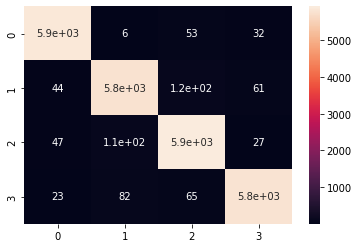

In [133]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
sns.heatmap(confusion_matrix(real_list,prediction_list), annot=True)